### Lite Loans Scorecard Development Plan ####
* Analyze & Breakdown Lite Loan Portfolio to learn about possible trends
 * POC Credit Scoring model for lite loans 
   * **Business Goal:** the main goal is to build a robust credit scoring model that aids automation and optimization of   customer on-boarding process from an application point of through-the-cycle strategy. The solution aims to meet the following requirements:
     * Reliability
     * Transparency 
     * Profit and Growth-driven
   * **Project Goal:** The Lite-loan credit risk application scorecard would assist in evaluating probability of customer defaults. This end-to-end advanced credit risk analytics would focuses on:
     * Meeting business goals 
     * Optimization of the overall customer acquisition funnel based on the association between the scoring model within GDS (and/or Provenir). 
     * Build a holistic customer risk profile for Lite-loan customers
  ##### PART 1 Data Preparation and Exporatory Data Analysis

  * Remove operationa risk ids
  * Data Audit: Verifying data quality
  * Distribution of Through-the-door Applications (Feb through Aug 2021) 
     * Understand take-up rates against total apps - the higher the take-up the higher the revenue generated  
  * Trend of Application Loan ticket size distribution 
  * Distribution of Through-the-door Loan Applications per Channel
  * Trend of Total Application population vs Acceptance rates vs decline rates month-on-month
  * Trend of top reasons for lite loan applications rejects
  * Trend of Disbursed Loan ticket size distribution month-on-month

  ##### Part 2 Behavioral Analysis

  * Analysis of early settlement events across the overall disbursed samples (Feb - Dec 2021)
  * Exclusion of early **settlement flag 1** from the disbursed population
  * Understanding Maximum delinquency event trends for Lite loans:
    * Default rates analysis 
    * Cure rates analysis
  * Define Target definition
    * Good/Bad flag
    
 ##### PART 3 Feature Engineering
  * Cross variables
  * Ratios

  ##### PART 4 Data Preparation
  * Characteristics Analysis Report
    * Fine Classing 
    * Coarse Classing 
    * Information value 
    * WoE transformations 
    * Univariate Analysis/ Feature Selection
  
 ##### PART 5 Scorecard Development
  * Modelling Phase
   * Variable Selection
  * Model Correlation Analysis
  * Model evaluation: 
     * Hold Out Sample Validation
     * Out-of-time validation
     * Recent sample validation
     * Score validation
     * Score calibration

##### PART 6 Cut off strategy
   * Cut-off Analysis
   * swap-set analysis
   * Profitability Analysis 
      * Cost Analysis: 
        * Dependecies (Unit Economics): 
          - Cost of customer acquisition
          - Marketing costs
          - overheads & variable cost
   * Probability of defaults Distribution (PDs)

     
   
     
  
  


  
  
  
  

In [1]:
# Load Dependences
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import datetime
import warnings
import re
from calendar import month_abbr
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('max_rows', None)
pd.set_option('max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

plt.style.use('ggplot')
%matplotlib inline
color = sns.color_palette()


warnings.filterwarnings("ignore")

# set display options
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
pd.options.display.float_format = "{:,.2f}".format

# Set plot styles
plt.style.use("ggplot")
%matplotlib inline
sns.set(style="whitegrid", color_codes=True)
color = sns.color_palette()

# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'
# Larger scale for plots in notebooks
sns.set_context('talk')

%run utils.ipynb
print('libraries imported successfully')


Util Libraries successfully imported
libraries imported successfully


### Read Datasets

In [2]:
#specify location of file
in_file_lite_loans = '\\\\10.0.10.20\\NetworkShare\\1. Active Projects\\Lite loans sc\\data\\raw\\Lite Application data Feb 2021 - Dec 2021.csv'
operatn_risk_loans = '\\\\10.0.10.20\\NetworkShare\\1. Active Projects\\Lite loans sc\\data\\raw\\SEL  LITE LOAN OPS.xlsx'

In [3]:

#read application data
lite_loan_apps = pd.read_csv(in_file_lite_loans, encoding='unicode_escape')

# Ensuring we exclude any duplicates found in the entire population
lite_loan_apps = lite_loan_apps.drop_duplicates(subset='LoanId', keep='first')


In [4]:
# checking for duplicates, after droping duplicates
print(lite_loan_apps.shape)
lite_loan_apps.LoanId.nunique()


(147837, 61)


147837

### Data Audit

##### Filter out Operational errors


In [5]:
#read operational risk data
operatn_errors = pd.read_excel(operatn_risk_loans)
operatn_errors = operatn_errors[[
    'Account ID', 'Card Correctness', 'Disb Date', 'Loan Grp', 'Bucket']]

# get loan ids for lite loans
operation_errors = operatn_errors[operatn_errors['Loan Grp'] == 'liteloan']
operation_errors['Loan Grp'].value_counts()

liteloan    2199
Name: Loan Grp, dtype: int64

In [6]:
#get unique counts of categories
operation_errors['Card Correctness'].value_counts()

Incorrectly Tokenized    1173
Incomplete BS             699
Remita Not activated      267
Expired Cards              60
Name: Card Correctness, dtype: int64

In [7]:
#show table
operation_errors.head(2)

,Account ID,Card Correctness,Disb Date,Loan Grp,Bucket
1,92000117,Remita Not activated,2021-02-06,liteloan,DPD000
2,92000193,Remita Not activated,2021-02-06,liteloan,WriteOf


In [8]:
# get id IDs
operation_errors_id = operation_errors['Account ID'].values

# filter the loan ids from the main application data
lite_loan_apps = lite_loan_apps[~lite_loan_apps['LoanId'].isin(operation_errors_id)]
lite_loan_apps.shape

(146137, 61)

In [9]:
#Data Audit to check for perecentage of missing and 0 values in dataframe
missing_zero_values_table(lite_loan_apps)

Your selected dataframe has 61 columns and 146137 Rows.
There are 61 columns that have missing values.


,No of 0s,% of 0s,No of Missing Values,% of Missing Values,Rows,No of Unique,Data Type
BureauData,144202,0.987,0,0.000,146137,2,int64
LoanId,0,0.000,0,0.000,146137,146137,int64
AccountState,0,0.000,0,0.000,146137,6,object
AccountSubstate,0,0.000,72054,0.500,146137,2,object
Product,0,0.000,0,0.000,146137,1,object
CreationDate,0,0.000,0,0.000,146137,323,object
DisbursementDate,0,0.000,138482,0.900,146137,328,object
DisbMonth,0,0.000,138482,0.900,146137,13,object
InitialDecision,0,0.000,0,0.000,146137,368,object
InitialDecisionCode,0,0.000,649,0.000,146137,3,object


#### INITIAL DATA EXPLORATION

In [10]:
lite_loan_apps.isnull().mean().round(4) * 100

BureauData                            0.000
LoanId                                0.000
AccountState                          0.000
AccountSubstate                      49.310
Product                               0.000
CreationDate                          0.000
DisbursementDate                     94.760
DisbMonth                            94.760
InitialDecision                       0.000
InitialDecisionCode                   0.440
ReasonCode_01                        96.360
Age                                   0.000
DocumentType                         44.210
DTI                                   0.000
EducationStatus                       0.000
EmployerLGA                          10.600
EmployerState                         4.730
Gender                                0.000
Income                                0.000
Industry                              0.000
LoanAmount                            0.000
MaritalStatus                         0.000
NoChildren                      

In [11]:
# Distribution of our Initial Decision Attributes by application volume
lite_loan_apps['InitialDecisionCode'].value_counts()

Accept                      140266
Decline - Policy Decline      5120
Decline - Low Score            102
Name: InitialDecisionCode, dtype: int64

In [12]:
lite_loan_apps['DocumentType'].unique()

array(['NIN', nan, 'BVN', 'Voters Identity Card', 'Drivers Licence',
       'Drivers License', 'Social Security Card',
       'International Passport', 'Employees Card', 'National ID',
       'Passport', 'National Identity Number', 'NIMC ID Card',
       'Lagos State Government Tax ID Card'], dtype=object)

In [13]:
# Distribution of Term Attributes by application volume
lite_loan_apps['Term'].value_counts()

1    145998
2       139
Name: Term, dtype: int64

In [14]:
# Distribution of Industry Attributes by application volume
lite_loan_apps['Industry'].value_counts()
# Output=False

Agriculture                                          20399
Services                                             15264
Consumer Goods                                       12100
Education                                            10898
Construction                                          9195
Wholesale and retail trade                            8278
Information and communication                         8013
Government                                            7885
Finance                                               6820
Manufacturing                                         5478
Null                                                  5296
Human health and social work activities               5118
Oil and Gas                                           4853
General                                               4446
Transportation and storage                            3976
Non-Governmental Organization                         3198
Arts, entertainment and recreation                    31

In [15]:
# Distribution of EducationStatus Attributes by application volume
lite_loan_apps['EducationStatus'].value_counts()
#Output = False


Graduate         75991
Secondary        23301
HND              18041
Post Graduate    16802
Primary           7489
Null              4460
Other               53
Name: EducationStatus, dtype: int64

In [16]:
# Distribution of MaritalStatus Attributes by application volume
lite_loan_apps['MaritalStatus'].value_counts()
#Output = False


Married      82301
Single       57983
Null          4713
Divorced       669
Widowed        467
Divorcee         2
Separated        1
Other            1
Name: MaritalStatus, dtype: int64

In [17]:
# Distribution of ResidentialStatus Attributes
lite_loan_apps['ResidentialStatus'].value_counts()
#Output = False


Renting               82427
Owner                 45266
With Relatives        12559
With Friends            838
Tenant                  357
With Parents             63
Commercial Renting       45
Other                    19
Social Renting           15
Not Given                 1
Not Captured              1
Name: ResidentialStatus, dtype: int64

In [18]:
# Distribution of Decision Reason by Volume
lite_loan_apps['ReasonCode_01'].value_counts()
#Output = False


Current Employment/Business Duration under 3 months    2348
Current Employment Duration under 3 months             1184
Location Policy Decline                                1052
Age Outside 22-65                                       209
Employer Check                                          125
Age Outside 18-65                                        89
BVN Unverified                                           81
Self-Employed                                            69
Last Sal >30 days ago                                    53
Loan Amount Below/Over Limit                             36
Low Income                                               34
Application accepted in last 3 months                    25
Accounts >30 DPD                                         10
No Income                                                 4
BusinessDuration                                          1
Card Expires within 3 months                              1
Name: ReasonCode_01, dtype: int64

In [19]:
# Distribution of AddressLGA Attributes by Volume
lite_loan_apps['AddresLGA'].value_counts()
#Output = False


Alimosho                  9545
Port Harcourt             9161
Abuja Municipal           7502
Abaji                     7395
Ikorodu                   5879
Agege                     4212
Eti-Osa                   3921
Ifako-Ijaye               3103
Ikeja                     2951
Ado-Odo/Ota               2885
Kosofe                    2829
Uyo                       2527
Bwari                     2494
Oshodi-Isolo              2443
Surulere                  2389
Ojo                       2177
Ibeju/Lekki               2049
Lagos Mainland            1983
Shomolu                   1639
Amuwo-Odofin              1616
Abeokuta North            1602
Ifo                       1479
Badagry                   1462
Mushin                    1384
Makurdi                   1382
Oredo                     1295
Benin                     1242
Gwagwalada                1213
Calabar Municipality      1170
Lagos Island              1132
Asaba                     1084
Ibadan Central            1081
Obafemi-

In [20]:
# Distribution of Channel Attributes by Volume
lite_loan_apps['Channels'].value_counts()


Renmobile         134321
Web App            11806
Internet               8
Contact Centre         1
Point of Sale          1
Name: Channels, dtype: int64

In [21]:
# Distribution of Gender Attributes by Volume
lite_loan_apps['Gender'].value_counts()


MALE      106754
FEMALE     39383
Name: Gender, dtype: int64

In [22]:
# Distribution of TimeEmploymentMM Attributes by Volume
lite_loan_apps['TimeEmploymentMM'].value_counts()
#Output = False


 0       7766
 24      1967
 27      1945
 26      1935
 28      1904
 36      1852
 25      1814
 29      1738
 40      1697
 39      1671
 30      1632
 48      1585
 37      1580
 35      1531
 38      1529
 34      1524
 31      1506
 41      1502
 32      1492
 33      1447
 23      1427
 42      1401
 46      1392
 52      1377
 22      1343
 51      1307
 15      1304
 14      1290
 45      1285
 44      1275
 47      1260
 60      1252
 12      1252
 16      1250
 13      1222
 43      1214
 53      1208
 50      1190
 21      1174
 49      1160
 17      1127
 20      1098
 54      1073
 64      1052
 19      1051
 11      1048
 18      1040
 72      1038
 9       1020
 2       1020
 10      1000
 57       999
 61       996
 58       983
 55       970
 65       964
 75       960
 63       953
 74       943
 56       928
 62       926
 76       916
 59       916
 66       916
 73       905
 67       895
 77       882
 8        877
 78       854
 84       854
 1        849
 69   

In [23]:
# Distribution of MobileNetwork Attributes by Volume
lite_loan_apps['MobileNetwork'].value_counts()
#Output = False


MTN            100836
AIRTEL          22342
GLO             13960
9mobile          8751
Others            240
STARCOMMS           5
ZOOM MOBILE         3
Name: MobileNetwork, dtype: int64

### PART 1 Analysis 
  * Distribution of Through-the-door Application
  * Trend of Application Loan ticket size distribution 
  * Distribution of Through-the-door Loan Applications per Channel
  * Trend of Total Application population vs Acceptance rates vs decline rates month-on-month
  * Trend of top reasons for lite loan applications rejects
  * Analysis of early settlement events across the overall disbursed samples (Feb - Dec 2021)
  * Trend of Disbursed Loan ticket size distribution month-on-month
  

In [24]:
lite_loan_apps.shape

(146137, 61)

In [25]:
lite_loan_apps.shape

(146137, 61)

In [26]:
# Distribution of reasons for Lite Loans Acceptance or Policy Declines
pd.crosstab(index=lite_loan_apps['ReasonCode_01'],
            columns=lite_loan_apps['InitialDecisionCode'])


InitialDecisionCode,Accept,Decline - Policy Decline
ReasonCode_01,,
Accounts >30 DPD,0,10
Age Outside 18-65,1,88
Age Outside 22-65,0,209
Application accepted in last 3 months,25,0
BVN Unverified,0,81
BusinessDuration,0,1
Card Expires within 3 months,1,0
Current Employment Duration under 3 months,3,1181
Current Employment/Business Duration under 3 months,66,2282


In [27]:
# Distribution of reasons for Lite Loans Acceptance or Policy Declines
pd.crosstab(index=lite_loan_apps['ReasonCode_01'],
            columns=lite_loan_apps['AccountSubstate'])


AccountSubstate,WITHDRAWN
ReasonCode_01,
Accounts >30 DPD,9
Age Outside 18-65,60
Age Outside 22-65,208
Application accepted in last 3 months,17
BVN Unverified,19
Card Expires within 3 months,1
Current Employment Duration under 3 months,1159
Current Employment/Business Duration under 3 months,350
Employer Check,58


##### LITE LOANS DECLINE REASON
The results of the above analysis shows us that most reason for Lite loan applications decline is because **"Applicants current employment duration is under 3 months"** while the second highest reasons for lite loan applications decline is because customers who applied for this loan are outside approved areas based on Renmoney's Credit Policy **Location Policy Decline**. 

##### SOME REASONS FOR ACCEPTS
Ideally, there isn't any reason populated for an accepted application under the reasoncode management fields on mambu. Strangely, As our analysis suggests, in some rare cases some Lite loans with an initial policy decline reason get an overriden decision of **Accept**. We will need to check with underwriting to get some further insights on why this is happening and it is normal to have such cases. The topmost reason for accepting a lite loan application is almost the same reason as the most significant reason we decline a customer based on our credit policy albeit with a different description **Current Employment/Business Duration under 3 months** and the second most significant reason is **Self-Employment** meaning this customers own an SME. 

#### Hypothetical Questions
Just for our understanding of the **Lite loan** products we give. If lite loans requested loan amount a customer can possibly apply for is between **6k and 20k**. 
* What is the least requested loan amount that a self-employed customer can get on **SEL** product and what is the least amount for a **Personal Loans Customer**?

In [28]:
! locale - a


'locale' is not recognized as an internal or external command,
operable program or batch file.


In [29]:
# let's try and format the current Creation date into '%m/%d/%Y'
lite_loan_apps['CreationDate'] = pd.to_datetime(
    lite_loan_apps['CreationDate'], format='%Y/%m/%d')
# we create a new column to store application month
lite_loan_apps['App_Month'] = lite_loan_apps['CreationDate'].dt.month_name(
    locale='en_US.utf8')
# Let's output distinct attributes for the application month feature
lite_loan_apps['App_Month'].unique()


array(['May', 'June', 'August', 'December', 'July', 'September',
       'November', 'October', 'March', 'April', 'February'], dtype=object)

In [30]:
# we try and create a new additional feature called application month-year e.g. 'Feb-2021'
lite_loan_apps['App_Mon_Year'] = lite_loan_apps['CreationDate'].dt.strftime(
    '%b-%Y')
# Let's output distinct attributes for this feature
lite_loan_apps['App_Mon_Year'].unique()


array(['May-2021', 'Jun-2021', 'Aug-2021', 'Dec-2021', 'Jul-2021',
       'Sep-2021', 'Nov-2021', 'Oct-2021', 'Mar-2021', 'Apr-2021',
       'Feb-2021'], dtype=object)

In [31]:
# Checking the distribution of our application volume
lite_loan_apps['App_Mon_Year'].value_counts()


Sep-2021    19331
Oct-2021    17265
Nov-2021    17016
Aug-2021    16435
Dec-2021    15759
Jun-2021    15269
Jul-2021    12470
May-2021    12257
Apr-2021     8371
Mar-2021     7636
Feb-2021     4328
Name: App_Mon_Year, dtype: int64

In [32]:
# Checking for the distinct attributes for our new Month-year field
lite_loan_apps['App_Mon_Year'].unique()


array(['May-2021', 'Jun-2021', 'Aug-2021', 'Dec-2021', 'Jul-2021',
       'Sep-2021', 'Nov-2021', 'Oct-2021', 'Mar-2021', 'Apr-2021',
       'Feb-2021'], dtype=object)

In [33]:
lite_loan_apps['App_Month'].nunique()


11

In [34]:
lite_loan_apps['InitialDecisionCode'].value_counts()['Accept']


140266

In [35]:
# We intend to see Application Month dimensioned by Volume of our distinct initial decision attributes
apps_cross_dim = pd.crosstab(lite_loan_apps['App_Mon_Year'],
                             lite_loan_apps['InitialDecisionCode'])

# Indexing our cross tab variable for ease of sorting, we convert from 'Feb-2021' to a datetime object
apps_cross_dim.index = pd.to_datetime(apps_cross_dim.index)

# Now, lets try and sort month-on-month Feb through Aug 2021
apps_cross_dim.sort_values(by=['App_Mon_Year'], inplace=True)

# Here, Lets now convert the new datetime object into a Month-Year format for ease of grouping
apps_cross_dim.index = apps_cross_dim.index.strftime('%b-%Y')

apps_cross_dim


InitialDecisionCode,Accept,Decline - Low Score,Decline - Policy Decline
App_Mon_Year,,,
Feb-2021,3190,28,1109
Mar-2021,6683,34,919
Apr-2021,7896,40,356
May-2021,11723,0,351
Jun-2021,14570,0,405
Jul-2021,12203,0,178
Aug-2021,16100,0,334
Sep-2021,18932,0,399
Oct-2021,16864,0,400


In [36]:
# Let's have a column with the total through-the-door application distribution MoM
apps_cross_dim['TTD_Apps'] = apps_cross_dim['Accept'] + \
    apps_cross_dim['Decline - Low Score'] + \
    apps_cross_dim['Decline - Policy Decline']


In [37]:
apps_cross_dim


InitialDecisionCode,Accept,Decline - Low Score,Decline - Policy Decline,TTD_Apps
App_Mon_Year,,,,
Feb-2021,3190,28,1109,4327
Mar-2021,6683,34,919,7636
Apr-2021,7896,40,356,8292
May-2021,11723,0,351,12074
Jun-2021,14570,0,405,14975
Jul-2021,12203,0,178,12381
Aug-2021,16100,0,334,16434
Sep-2021,18932,0,399,19331
Oct-2021,16864,0,400,17264


In [38]:
# Let's obtain new columns for Accept.Rates
apps_cross_dim['Accept_Rates'] = apps_cross_dim['Accept'] / apps_cross_dim['TTD_Apps']

# Let's obtain new columns for LSD.Rates
apps_cross_dim['LSD_Rates'] = apps_cross_dim['Decline - Low Score'] / apps_cross_dim['TTD_Apps']

# Let's obtain new columns for PolicyDecline.Rates
apps_cross_dim['Policy_Decline_Rates'] = apps_cross_dim['Decline - Policy Decline'] / apps_cross_dim['TTD_Apps']

#apps_cross_dim.to_csv('application_lite.csv')


In [39]:
#apps_cross_dim.to_csv('TTD Applications - Lite Loans.csv')


In [40]:
apps_cross_dim.index.size


11

<AxesSubplot:xlabel='InitialDecisionCode', ylabel='App_Month'>

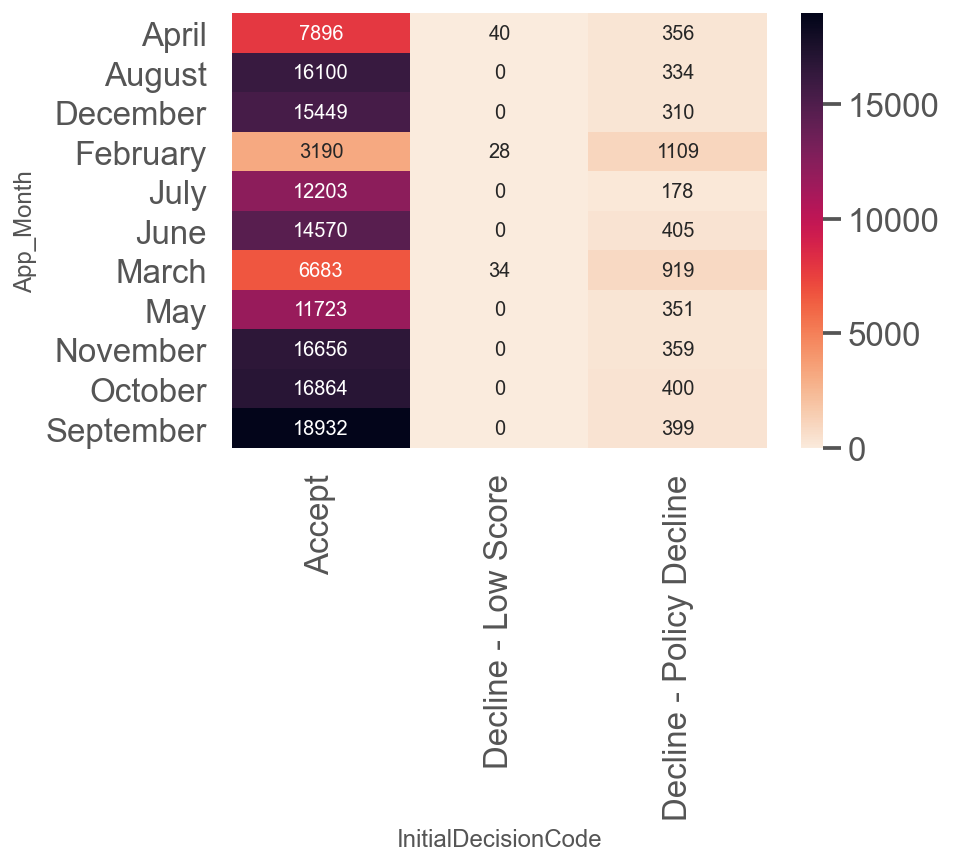

In [41]:
# visualizing a heat map that shows us our initial decision distribution for Lite loans
apps_cross = pd.crosstab(index=lite_loan_apps['App_Month'],
                         columns=lite_loan_apps['InitialDecisionCode'])
sns.heatmap(apps_cross, cmap='rocket_r', annot=True, fmt='g')


In [42]:
lite_loan_apps['LoanId'].shape[0]


146137

In [43]:
# Distribution of through-the-door applications by Channel
app_channel_dist = lite_loan_apps.groupby(
    'Channels', as_index=False)['LoanId'].count()


In [44]:
app_channel_dist = app_channel_dist.rename(
    columns={'LoanId': 'Application_Volume'})


In [45]:
app_channel_dist = app_channel_dist.reset_index(drop=True)


In [46]:
# Distribution of channels per Through-the-door applications
app_channel_dist


,Channels,Application_Volume
0,Contact Centre,1
1,Internet,8
2,Point of Sale,1
3,Renmobile,134321
4,Web App,11806


In [47]:
apps_cross_dim[['Accept', 'Decline - Low Score', 'Decline - Policy Decline']]


InitialDecisionCode,Accept,Decline - Low Score,Decline - Policy Decline
App_Mon_Year,,,
Feb-2021,3190,28,1109
Mar-2021,6683,34,919
Apr-2021,7896,40,356
May-2021,11723,0,351
Jun-2021,14570,0,405
Jul-2021,12203,0,178
Aug-2021,16100,0,334
Sep-2021,18932,0,399
Oct-2021,16864,0,400


In [48]:
apps_cross_dim2 = apps_cross_dim[[
    'Accept', 'Decline - Low Score', 'Decline - Policy Decline']]


In [49]:
apps_cross_dim2.dtypes


InitialDecisionCode
Accept                      int64
Decline - Low Score         int64
Decline - Policy Decline    int64
dtype: object

In [50]:
# now stack and reset
stacked = apps_cross_dim2.stack().reset_index().rename(columns={0: 'value'})


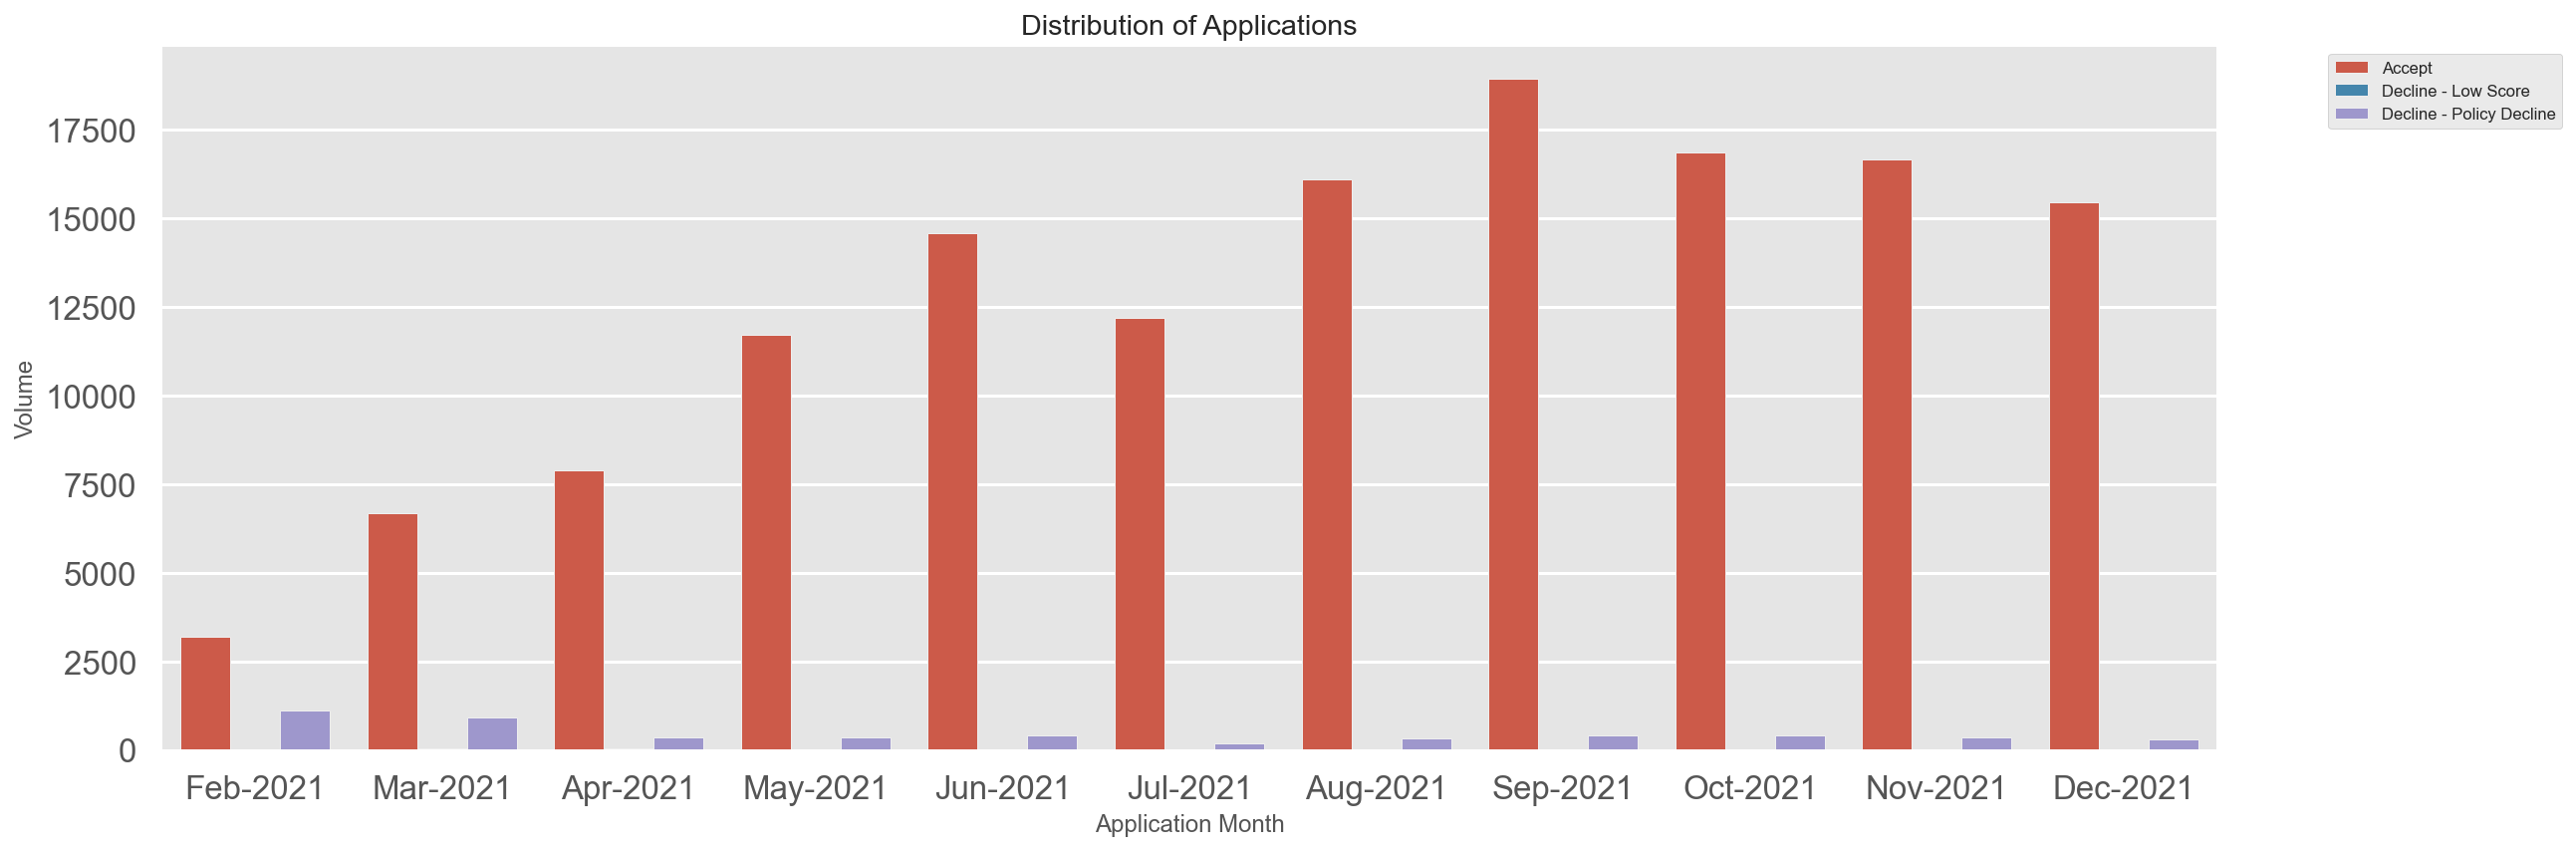

In [51]:
# plot grouped bar chart
p = sns.barplot(x=stacked.App_Mon_Year, y=stacked.value, hue=stacked.InitialDecisionCode, order=[
                'Feb-2021', 'Mar-2021', 'Apr-2021', 'May-2021', 'Jun-2021', 'Jul-2021', 'Aug-2021', 'Sep-2021', 'Oct-2021', 'Nov-2021', 'Dec-2021'])
#sns.move_legend(p, bbox_to_anchor=(1, 1.03), loc=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2,
           fontsize='small')  # borderaxespad=0.)
plt.title('Distribution of Applications')
# l=ax.legend(loc='best',fontsize='small')

p.set_xlabel('Application Month')
p.set_ylabel('Volume')
fig = p.figure
fig.set_size_inches(18, 6)
fig.tight_layout(pad=1)
#fig.savefig('filename.png', dpi=125)
# plt.close()


In [52]:
# Lets instantiate a variable a new data frame to hold both total apps and accept rates
df_AR = apps_cross_dim[['TTD_Apps', 'Accept_Rates']]


In [53]:
df_AR

# now stack and reset
df_AR = df_AR.stack().reset_index().rename(columns={0: 'value'})


In [54]:
# App_Mon_year initial decision code Value Accept_rate
# Feb 2021       TTD APPS            4457   0.74


In [55]:
df_AR
Output = False


In [56]:
stacked
Output = False


In [57]:
#fig, ax = plt.subplots()
#ax2 = ax.twinx()
#ax.bar(apps_cross_dim.App_Month_Year, apps_cross_dim["TTD_Apps"], color=(190/255,190/255,190/255,0.7), label='Release')
#ax = sns.barplot(x=df_AR.App_Mon_Year, y=df_AR.value, hue=stacked.InitialDecisionCode, order=['Feb-2021', 'Mar-2021', 'Apr-2021', 'May-2021','Jun-2021','Jul-2021','Aug-2021'])
#ax.bar(df_AR.App_Month_Year, df_AR["TTD_Apps"], label='TTD Applications',order=['Feb-2021', 'Mar-2021', 'Apr-2021', 'May-2021','Jun-2021','Jul-2021','Aug-2021'])
#ax2.plot(df_AR.App_Month_Year, df_AR.value, color='green', label='Accept Rates')
#ax2=sns.FacetGrid(df_AR.App_Mon_Year, row=df_AR.value, hue=stacked.InitialDecisionCode, size=3, aspect=3)
# ax2=sns.lineplot(TTD_Apps)
# ax.set_xticklabels(df_AR.App_Mon_Year)
# ax.legend(loc='best')


In [58]:
apps_cross_dim.columns


Index(['Accept', 'Decline - Low Score', 'Decline - Policy Decline', 'TTD_Apps',
       'Accept_Rates', 'LSD_Rates', 'Policy_Decline_Rates'],
      dtype='object', name='InitialDecisionCode')

In [59]:
# We intend to see Application Month dimensioned by Volume of our distinct channel attributes
apps_cross_channel = pd.crosstab(lite_loan_apps['App_Mon_Year'],
                                 lite_loan_apps['Channels'])

# Indexing our cross tab variable for ease of sorting, we convert from 'Feb-2021' to a datetime object
apps_cross_channel.index = pd.to_datetime(apps_cross_dim.index)

# Now, lets try and sort month-on-month Feb through Aug 2021
apps_cross_channel.sort_values(by=['App_Mon_Year'], inplace=True)

# Here, Lets now convert the new datetime object into a Month-Year format for ease of grouping
apps_cross_channel.index = apps_cross_channel.index.strftime('%b-%Y')

apps_cross_channel


Channels,Contact Centre,Internet,Point of Sale,Renmobile,Web App
App_Mon_Year,,,,,
Feb-2021,0,0,0,7439,932
Mar-2021,0,1,0,15108,1326
Apr-2021,1,0,0,15016,742
May-2021,0,2,0,3863,463
Jun-2021,0,1,0,11231,1238
Jul-2021,0,1,0,13598,1670
Aug-2021,0,1,0,6775,860
Sep-2021,0,2,0,10968,1287
Oct-2021,0,0,1,16113,902


In [60]:
# now stack and reset index
apps_cross_channel = apps_cross_channel.stack(
).reset_index().rename(columns={0: 'value'})


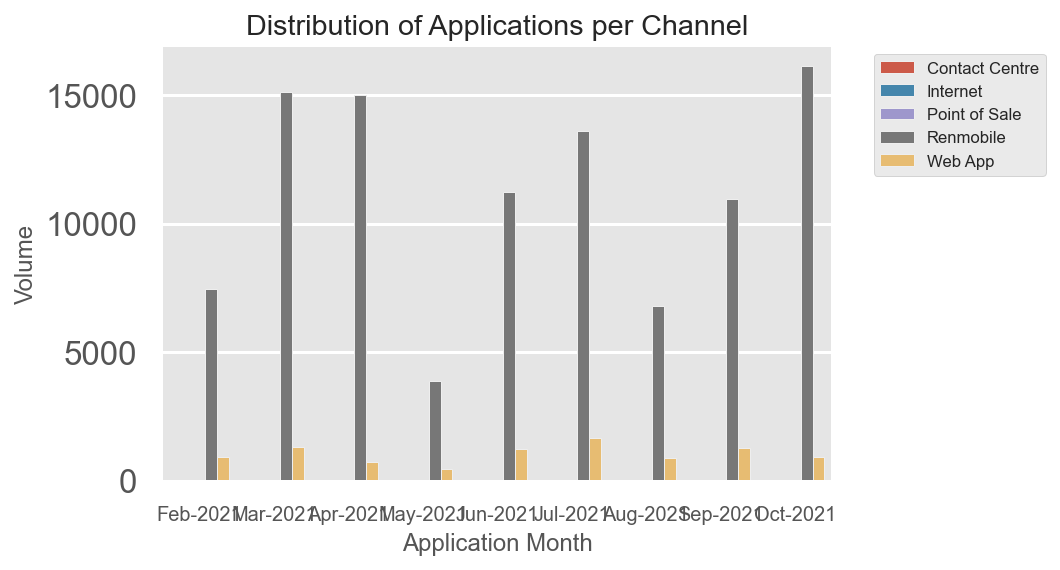

In [61]:
# plot grouped bar chart
ax = sns.barplot(x=apps_cross_channel.App_Mon_Year, y=apps_cross_channel.value, hue=apps_cross_channel.Channels, order=[
                 'Feb-2021', 'Mar-2021', 'Apr-2021', 'May-2021', 'Jun-2021', 'Jul-2021', 'Aug-2021', 'Sep-2021', 'Oct-2021'])
#sns.move_legend(p, bbox_to_anchor=(1, 1.03), loc=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2,
           fontsize='small')  # borderaxespad=0.)
plt.title('Distribution of Applications per Channel')
# l=ax.legend(loc='best',fontsize='small')

ax.set_xlabel('Application Month')
ax.set_ylabel('Volume')
fig = p.figure
fig.set_size_inches(20, 4)
# ax.set_xticklabels(apps_cross_channel.App_Mon_Year)
fig.tight_layout(pad=1)
plt.tick_params(axis='x', which='major', labelsize=10)
#fig.savefig('filename.png', dpi=125)
# plt.close()


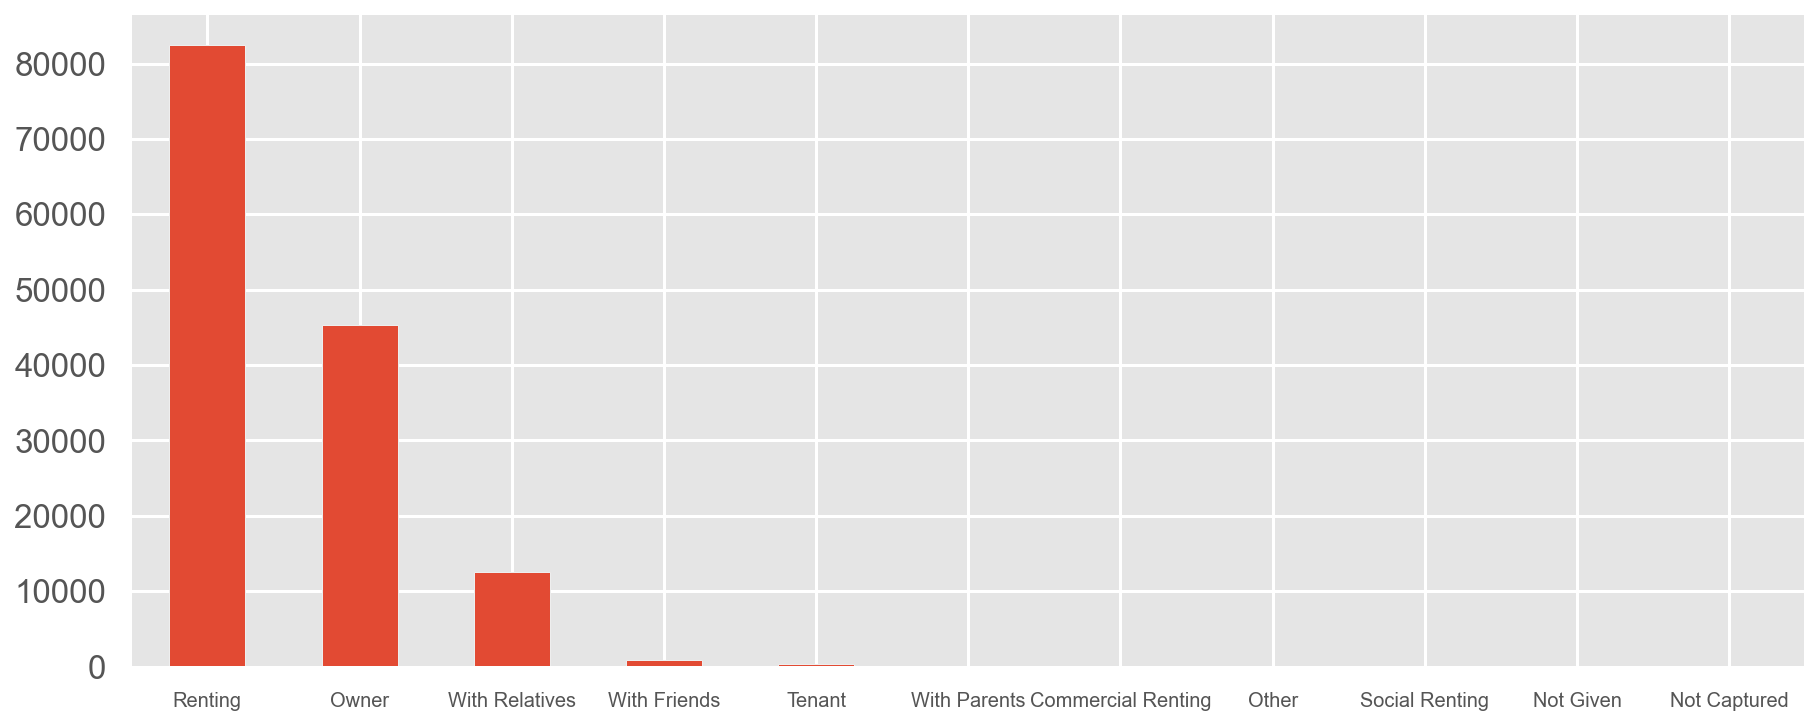

In [62]:
# Through-the-door application distribution by Residential Status
plt.figure(figsize=(15, 6))
lite_loan_apps.ResidentialStatus.value_counts().plot(kind='bar', rot=0)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.show()


In [63]:
lite_loan_apps['clientID']  = lite_loan_apps['clientID'].astype(str)
lite_loan_apps['LoanId']  = lite_loan_apps['LoanId'].astype(str)

In [64]:
lite_loan_apps['DisbursementDate'] = pd.to_datetime(lite_loan_apps['DisbursementDate'])

# drop repeat customers
#sort values
lite_loan_apps.sort_values(by=['DisbursementDate'], ascending=True, inplace=True)

# # Ensuring we exclude any duplicates found in the entire population
lite_loan_apps = lite_loan_apps[~lite_loan_apps['DisbMonth'].isna()]
lite_loan_apps = lite_loan_apps.drop_duplicates(subset='clientID', keep='first')

In [65]:
#write development data to a location
lite_loan_apps.to_csv('\\\\10.0.10.20\\NetworkShare\\1. Active Projects\\Lite loans sc\\data\\processed\\1.0 lite loans data after audit.csv')